In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
plt.rcParams.update({
    "font.family": "serif",  # use serif/main font for text elements
    "text.usetex": False,     # use inline math for ticks
    "pgf.rcfonts": False,    # don't setup fonts from rc parameters
})

In [2]:
from pathlib import Path
import os

In [7]:
import pp_util
import importlib
importlib.reload(pp_util)

<module 'pp_util' from '/home/jsewall/misc/pp/2020/metrics/scripts/pp_util.py'>

In [4]:
qual_colormap = plt.get_cmap("tab10")
plat_order=["OpenMP", "Kokkos", "CUDA", "OpenACC", "OpenCL"]
import os
csv_root="../data/"
colordict ={}
for idx, name in enumerate(plat_order):
    colordict[name] = qual_colormap(idx)
patches = {}
for p in plat_order:
    patches[p] = Rectangle((0, 0), 1, 1, fc=colordict[p])

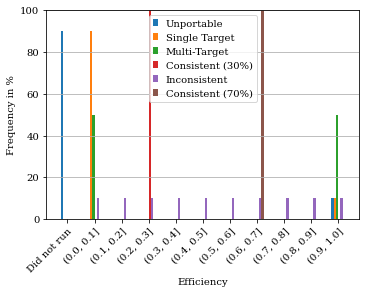

In [8]:
fig = plt.figure(figsize=(5, 4))
ax = fig.add_subplot(1,1,1)
app_eff = pp_util.read_effs(os.path.join(csv_root, "synthetic.csv"), skip_plats=True)
app_eff = sorted(list(app_eff.items()), key=lambda x: pp_util.harmean(x[1]))
pp_util.binplot(ax, app_eff, False) 

L=plt.legend()
texts = [ m.get_text().replace(r"\%", "%") for m in L.get_texts()]
plt.tight_layout(pad=0.4,w_pad=1.5, h_pad=0.5)
plt.legend(loc= "upper center", handlelength=0.5, labels=texts)
plt.savefig("binned_chart_synthetic.pdf", bbox_inches="tight")

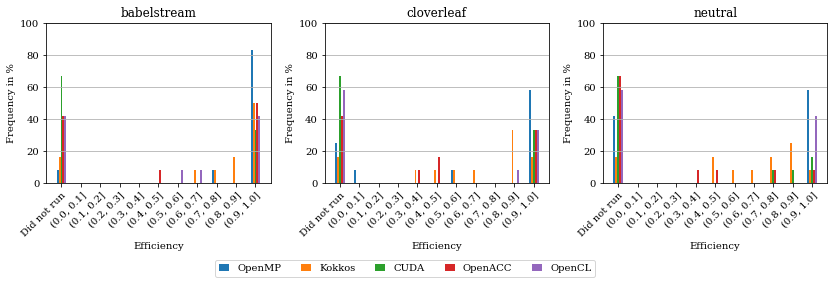

In [9]:
fig = plt.figure(figsize=(11.5, 3.5))
for i, appfile in enumerate(["babelstream.csv", "cloverleaf.csv", "neutral.csv"]):
    ax = fig.add_subplot(1,3,i+1)
    throughput=(appfile == "babelstream.csv")
    pp_util.load_app_perfs(os.path.join(csv_root, appfile), throughput=throughput)
    effs = []
    for p in plat_order:
        ae=pp_util.app_effs(pp_util.apps[p], pp_util.platforms.keys(), throughput=throughput)
        effs.append((p, [x[1] for x in ae]))     
    handles = pp_util.binplot(ax, effs, colordict)
    plt.title(Path(appfile).stem)
handles_names, handles_items = zip(*patches.items())
fig.legend(handles_items, handles_names, loc='upper left', ncol=5, handlelength=1.0, bbox_to_anchor=(0.25,0.0))
plt.tight_layout(pad=0.4,w_pad=1.5, h_pad=0.5)
plt.savefig("binned_chart_tiled.pdf", bbox_inches="tight")